## DATA PREPARATION

In [1]:
import pandas as pd

df = pd.read_csv('samur_2020.csv', sep=';')
df.head()

,Año,Mes,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital
0,2020,ENERO,0:03:21,0:08:49,Accidente de monopatin,ARGANZUELA,NaN
1,2020,ENERO,0:04:03,0:14:44,Patología obstétrica,SAN BLAS,NaN
2,2020,ENERO,0:04:05,0:10:12,Inconsciente sin filiar causa,VILLA DE VALLECAS,NaN
3,2020,ENERO,0:05:09,0:13:15,Incendio,VALLECAS PTE.,NaN
4,2020,ENERO,0:07:43,0:16:19,Agresión sin especificar,VALLECAS PTE.,NaN


In [2]:
df.columns = ['YEAR', 'MONTH', 'HOUR_REQUEST', 'HOUR_INTERVENTION', 'CODE', 'DISTRICT', 'HOSPITAL']
df = df.dropna(subset=['HOUR_REQUEST', 'HOUR_INTERVENTION'])
df.head()

,YEAR,MONTH,HOUR_REQUEST,HOUR_INTERVENTION,CODE,DISTRICT,HOSPITAL
0,2020,ENERO,0:03:21,0:08:49,Accidente de monopatin,ARGANZUELA,NaN
1,2020,ENERO,0:04:03,0:14:44,Patología obstétrica,SAN BLAS,NaN
2,2020,ENERO,0:04:05,0:10:12,Inconsciente sin filiar causa,VILLA DE VALLECAS,NaN
3,2020,ENERO,0:05:09,0:13:15,Incendio,VALLECAS PTE.,NaN
4,2020,ENERO,0:07:43,0:16:19,Agresión sin especificar,VALLECAS PTE.,NaN


In [3]:
def time_difference(from_date, to_date):
    import math
    from datetime import datetime    
    FMT = '%H:%M:%S'
    tdelta = datetime.strptime(to_date, FMT) - datetime.strptime(from_date, FMT)
    solution = math.floor(tdelta.seconds / 60)
    return solution


In [4]:
def fix_midnight(date):
    str_repr = str(date)
    is_wrong = str_repr.startswith('0:')
    
    if (is_wrong):
        hour, minutes, seconds = date.split(':')
        return ':'.join(['00', minutes, seconds])
                            
    return date

In [5]:
month_codes, _    = pd.factorize(df['MONTH'])
code_codes, _     = pd.factorize(df['CODE'])
district_codes, _ = pd.factorize(df['DISTRICT'])
hospital_codes, _ = pd.factorize(df['HOSPITAL'])

df['MONTH']              = month_codes
df['CODE']               = code_codes
df['DISTRICT']           = district_codes
df['HOSPITAL']           = hospital_codes
df['HOUR_REQUEST']       = df['HOUR_REQUEST'].apply(fix_midnight)
df['HOUR_INTERVENTION']  = df['HOUR_INTERVENTION'].apply(fix_midnight)
df['MINUTES_TO_RESPOND'] = df.\
    loc[:, ['HOUR_REQUEST', 'HOUR_INTERVENTION']].\
    T.\
    apply(lambda x: time_difference(x[0], x[1]))

In [6]:
import numpy as np

average_time_to_respond = np.floor(np.average(df['MINUTES_TO_RESPOND']))
average_time_to_respond

9.0

In [7]:
df['HOUR'] = df['HOUR_REQUEST'].apply(lambda v: int(v.split(':')[0]))
df['ABOVE_AVG'] = df['MINUTES_TO_RESPOND'].apply(lambda v: 1 if v > average_time_to_respond else 0)
df.head()

,YEAR,MONTH,HOUR_REQUEST,HOUR_INTERVENTION,CODE,DISTRICT,HOSPITAL,MINUTES_TO_RESPOND,HOUR,ABOVE_AVG
0,2020,0,00:03:21,00:08:49,0,0,-1,5,0,0
1,2020,0,00:04:03,00:14:44,1,1,-1,10,0,1
2,2020,0,00:04:05,00:10:12,2,2,-1,6,0,0
3,2020,0,00:05:09,00:13:15,3,3,-1,8,0,0
4,2020,0,00:07:43,00:16:19,4,3,-1,8,0,0


## Feature selection

In [8]:
cols  = ['YEAR', 'MONTH', 'CODE', 'DISTRICT', 'HOSPITAL', 'HOUR', 'ABOVE_AVG']
samur = df[cols]
samur.head()

,YEAR,MONTH,CODE,DISTRICT,HOSPITAL,HOUR,ABOVE_AVG
0,2020,0,0,0,-1,0,0
1,2020,0,1,1,-1,0,1
2,2020,0,2,2,-1,0,0
3,2020,0,3,3,-1,0,0
4,2020,0,4,3,-1,0,0


### Correlation Matrix

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

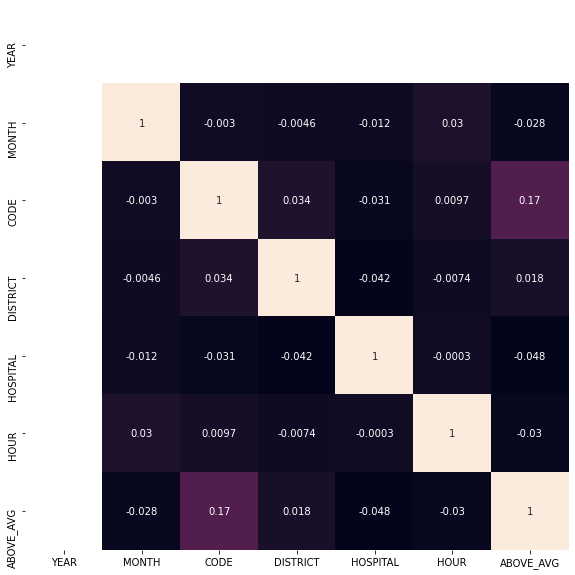

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_matrix = np.corrcoef(samur.T)

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    cbar=False,
    annot=True,
    square=True,
    xticklabels=samur.columns,
    yticklabels=samur.columns)

### Imbalance analysis

In [10]:
df.loc[:, ["ABOVE_AVG", "MONTH"]]\
    .groupby("ABOVE_AVG")\
    .count()\
    .rename(columns={"MONTH": "COUNT"})\
    .reset_index()\
    .sort_values("ABOVE_AVG", ascending=False)

,ABOVE_AVG,COUNT
1,1,28268
0,0,75583


In [11]:
from sklearn.model_selection import train_test_split

columns = ['YEAR', 'MONTH', 'CODE', 'DISTRICT', 'HOSPITAL', 'HOUR']
target  = 'ABOVE_AVG'

X = samur[columns]
y = samur[target]

In [12]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -U imbalanced-learn

Because there are many samples, I think is going to be counter-productive to add more samples. I'm ok just having the same amount of positive samples than negative ones. For that I'm using an under-sampling algorithm from imlearn

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus  = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs         = SelectKBest(f_classif, k=5)
X_selected = fs.fit_transform(X, y)
cols       = fs.get_support(indices=True)
df_best    = samur.iloc[:, cols]

print("BEST 5 FEATURES: {}".format(samur.iloc[:, cols].columns.values))

BEST 5 FEATURES: ['MONTH' 'CODE' 'DISTRICT' 'HOSPITAL' 'HOUR']


/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## CONFUSION MATRICES

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# different classifiers
logistic    = LogisticRegression().fit(X_train, y_train)
svc         = LinearSVC(random_state=0).fit(X_train, y_train)
knn         = KNeighborsClassifier(5).fit(X_train, y_train)
tree        = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
rff         = RandomForestClassifier(max_depth=2, n_estimators=4, max_features=2).fit(X_train, y_train)
ada         = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
dummy       = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
classifiers = [dummy, logistic, svc, knn, tree, rff, ada]

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [19]:
from sklearn.metrics import confusion_matrix

for clsf in classifiers:
    y_predicted = clsf.predict(X_test)
    print(clsf.__class__.__name__)
    print('===========================================')
    print(confusion_matrix(y_test, y_predicted))
    print()

DummyClassifier
[[7053    0]
 [7081    0]]

LogisticRegression
[[4944 2109]
 [3685 3396]]

LinearSVC
[[   0 7053]
 [   0 7081]]

KNeighborsClassifier
[[4273 2780]
 [2732 4349]]

DecisionTreeClassifier
[[5825 1228]
 [4486 2595]]

RandomForestClassifier
[[4631 2422]
 [3381 3700]]

AdaBoostClassifier
[[4934 2119]
 [3054 4027]]



## CLASSIFICATION REPORTS

In [17]:
from sklearn.metrics import classification_report

# creating their confusion matrices
for clsf in classifiers:
    y_predicted = clsf.predict(X_test)
    print(clsf.__class__.__name__)
    print('===========================================')
    print(classification_report(y_test, y_predicted, target_names = ['above_avg', 'not_above_avg']))

DummyClassifier
               precision    recall  f1-score   support

    above_avg       0.50      1.00      0.67      7053
not_above_avg       0.00      0.00      0.00      7081

     accuracy                           0.50     14134
    macro avg       0.25      0.50      0.33     14134
 weighted avg       0.25      0.50      0.33     14134

LogisticRegression
               precision    recall  f1-score   support

    above_avg       0.57      0.70      0.63      7053
not_above_avg       0.62      0.48      0.54      7081

     accuracy                           0.59     14134
    macro avg       0.59      0.59      0.59     14134
 weighted avg       0.59      0.59      0.58     14134

LinearSVC
               precision    recall  f1-score   support

    above_avg       0.00      0.00      0.00      7053
not_above_avg       0.50      1.00      0.67      7081

     accuracy                           0.50     14134
    macro avg       0.25      0.50      0.33     14134
 weighted av

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

KNeighborsClassifier
               precision    recall  f1-score   support

    above_avg       0.61      0.61      0.61      7053
not_above_avg       0.61      0.61      0.61      7081

     accuracy                           0.61     14134
    macro avg       0.61      0.61      0.61     14134
 weighted avg       0.61      0.61      0.61     14134

DecisionTreeClassifier
               precision    recall  f1-score   support

    above_avg       0.56      0.83      0.67      7053
not_above_avg       0.68      0.37      0.48      7081

     accuracy                           0.60     14134
    macro avg       0.62      0.60      0.57     14134
 weighted avg       0.62      0.60      0.57     14134

RandomForestClassifier
               precision    recall  f1-score   support

    above_avg       0.58      0.66      0.61      7053
not_above_avg       0.60      0.52      0.56      7081

     accuracy                           0.59     14134
    macro avg       0.59      0.59      0.59 